In [1]:
import pandas as pd
import numpy as np
import psycopg2
import decimal

import datetime
import random

from sqlalchemy import create_engine

import matplotlib.pyplot as plt

import seaborn as sns

In [2]:

upper_pc_threshold = 0.04
lower_pc_threshold = 0.04

days_before_action = 4

start_date = pd.to_datetime('2010-01-01').date()
end_date = pd.to_datetime('2021-12-31').date()

ma_days =[12, 15, 18, 20 ,23 ]

# set plot size 
sns.set(rc={'figure.figsize':(18, 12)})

# show more rows
pd.set_option('display.max_rows', None)

In [3]:


POSTGRES_ADDRESS = '192.168.1.27'
POSTGRES_PORT = '5433' 
POSTGRES_USERNAME = 'root' 
POSTGRES_PASSWORD = 'password' 
POSTGRES_DBNAME = 'pystock' 

postgres_str = ('postgresql://{username}:{password}@{ipaddress}:{port}/{dbname}'
                .format(username=POSTGRES_USERNAME, 
                        password=POSTGRES_PASSWORD, 
                        ipaddress=POSTGRES_ADDRESS, 
                        port=POSTGRES_PORT, 
                        dbname=POSTGRES_DBNAME)) 
# Create the connection 
cnx = create_engine(postgres_str)
pg_prices=pd.read_sql_query('''SELECT * FROM inputs.prices WHERE ticker = 'HSBA.L' AND price_date BETWEEN '2010-01-01' AND '2022-08-30';''', cnx)
prices=pg_prices.sort_values(by=['price_date'])
prices = prices.set_index('price_date')
prices.index = pd.DatetimeIndex(prices.index).to_period('D')


pg_test_prices=pd.read_sql_query('''SELECT * FROM inputs.prices WHERE ticker = 'HSBA.L' AND price_date BETWEEN '2022-06-02' AND '2022-08-30';''', cnx)
test_prices=pg_test_prices.sort_values(by=['price_date'])
test_prices = test_prices.set_index('price_date')
test_prices.index = pd.DatetimeIndex(test_prices.index).to_period('D')


pg_train_prices=pd.read_sql_query('''SELECT * FROM inputs.prices WHERE ticker = 'HSBA.L' AND price_date BETWEEN '2010-01-01' AND '2022-06-01';''', cnx)
train_prices=pg_train_prices.sort_values(by=['price_date'])
train_prices = train_prices.set_index('price_date')
train_prices.index = pd.DatetimeIndex(train_prices.index).to_period('D')




In [4]:
numdays = 100
predictdays = 30
base = datetime.date.today()
train_prices = pd.DataFrame(
    {'price_date': [base + datetime.timedelta(days=x) for x in range(numdays)],
     'close_price': [12 + random.random() for x in range(numdays)]
    })
train_prices = train_prices.sort_values(by=['price_date'])
train_prices = train_prices.set_index('price_date')
train_prices.index = pd.DatetimeIndex(train_prices.index).to_period('D')

prices = pd.DataFrame(
    {'price_date': [base + datetime.timedelta(days=x) for x in range(numdays + predictdays)],
     'close_price': [12 + random.random() for x in range(numdays + predictdays)]
    })
prices = prices.sort_values(by=['price_date'])
prices = prices.set_index('price_date')
prices.index = pd.DatetimeIndex(prices.index).to_period('D')



## Forecast stuff

In [5]:

close_prices = pd.DataFrame(prices.close_price.copy())
test_close_prices = test_prices.close_price.copy()
train_close_prices = pd.DataFrame(train_prices.close_price.copy())

<Axes: xlabel='price_date'>

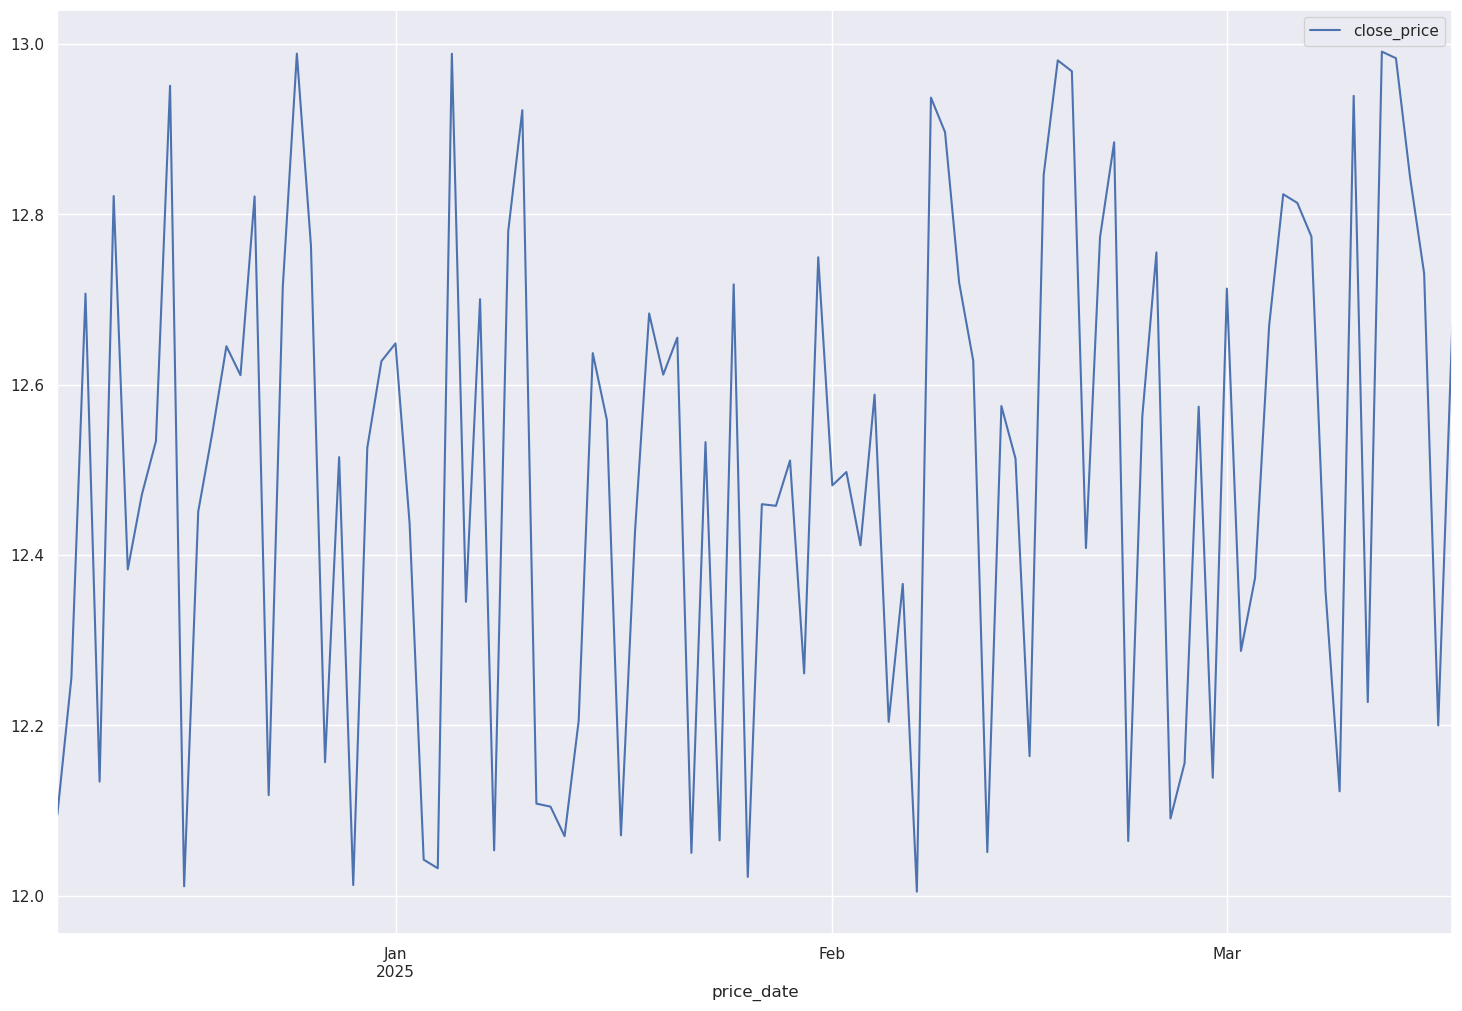

In [6]:
train_close_prices.plot()

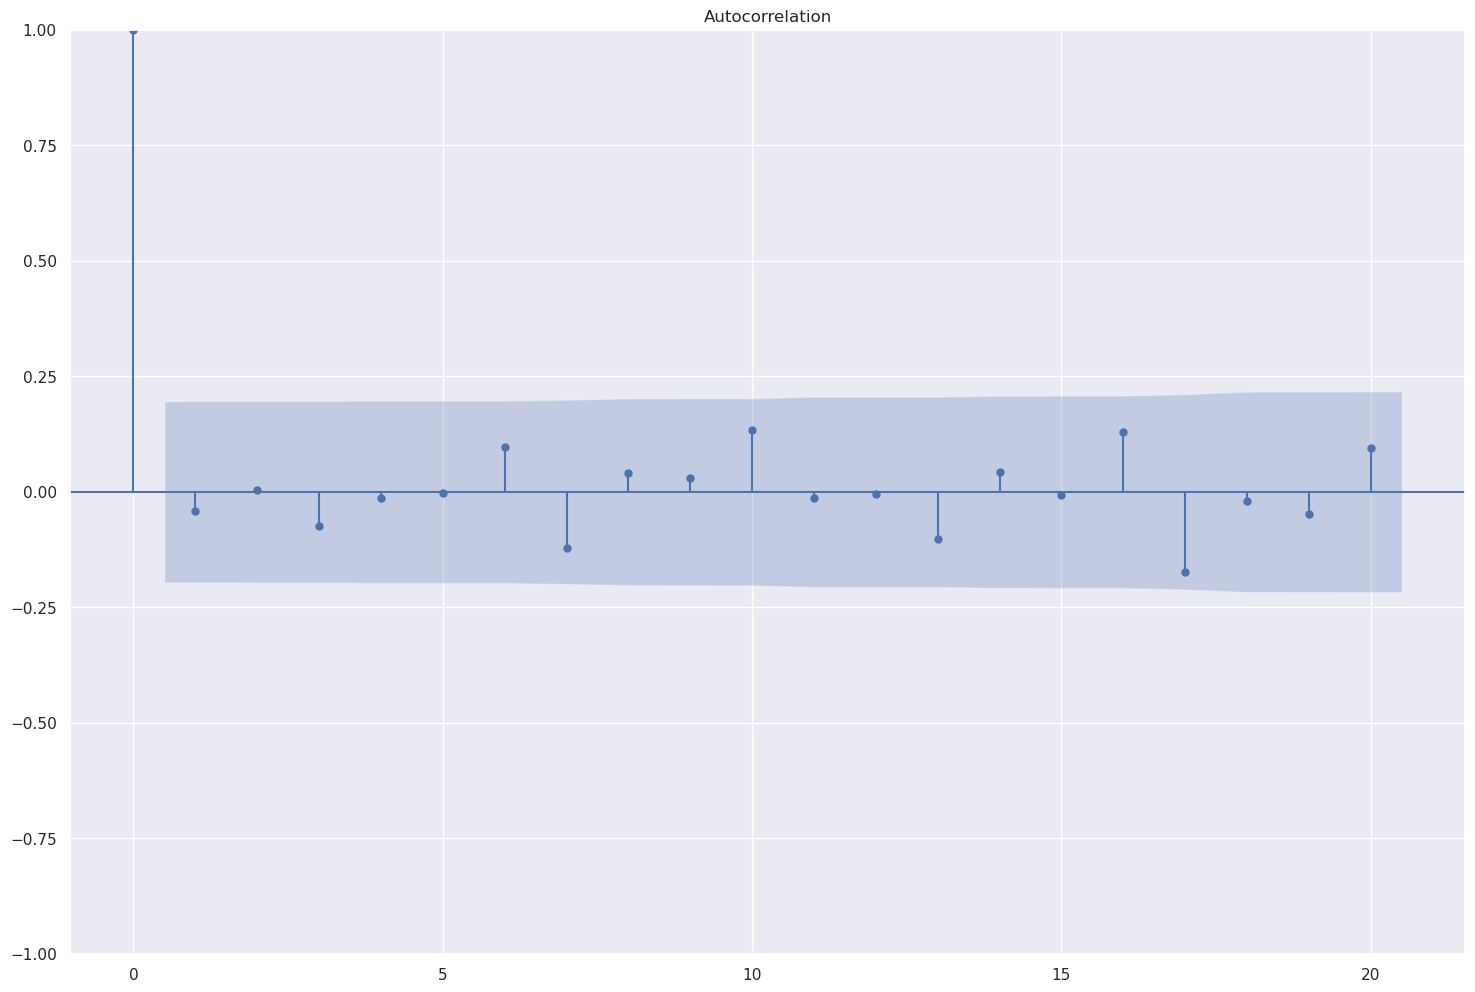

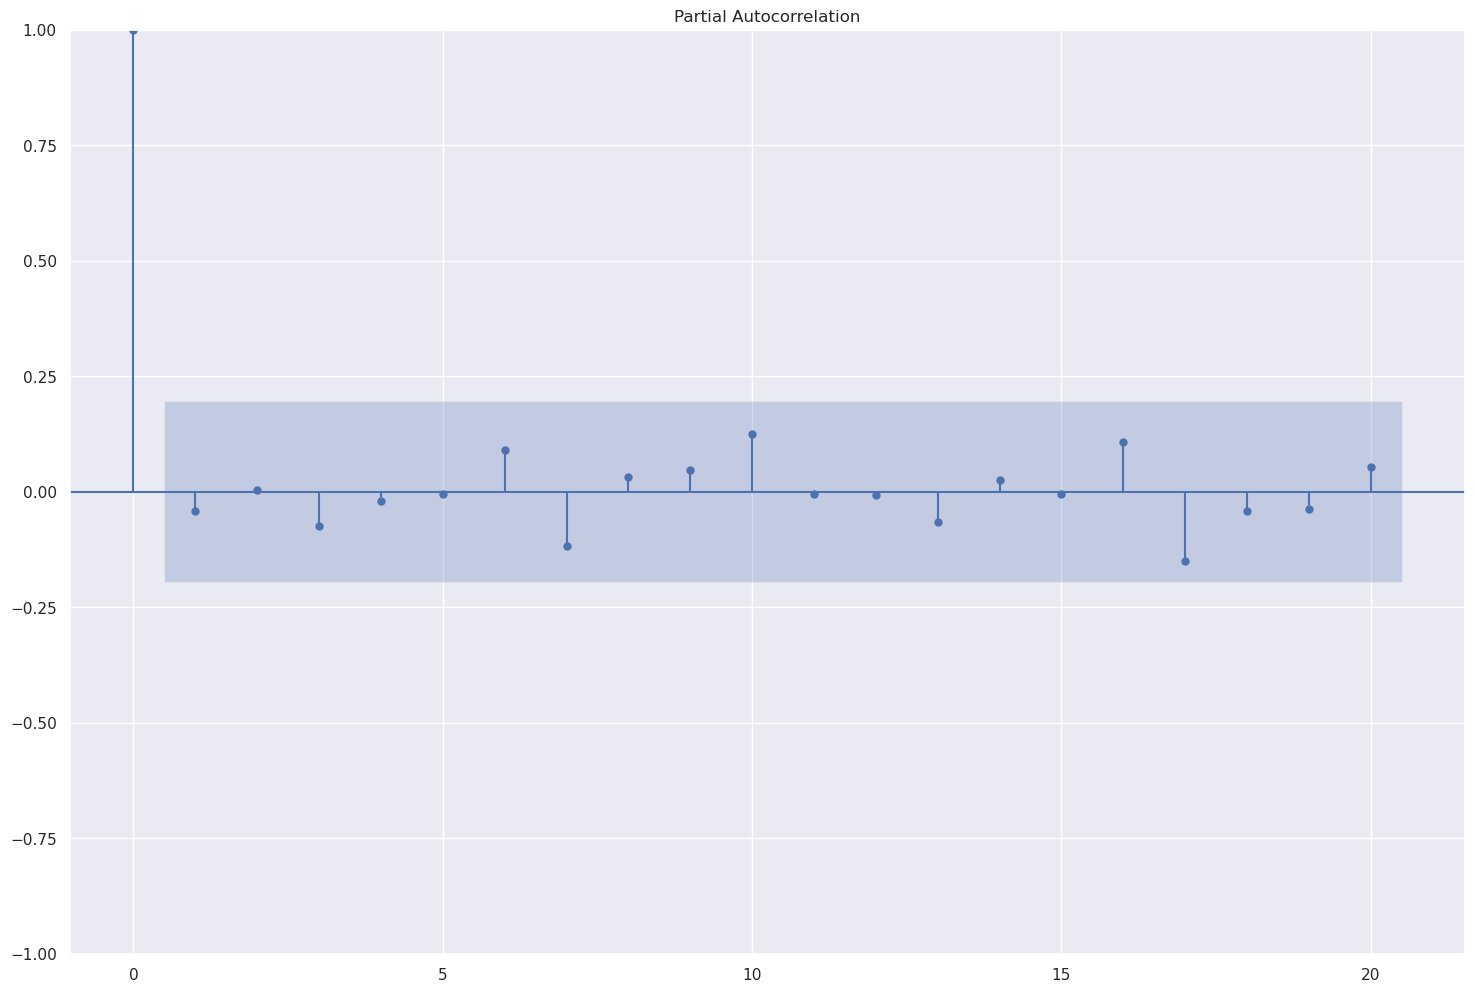

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

acf_original = plot_acf(train_close_prices)

pacf_original = plot_pacf(train_close_prices)

<Axes: xlabel='price_date'>

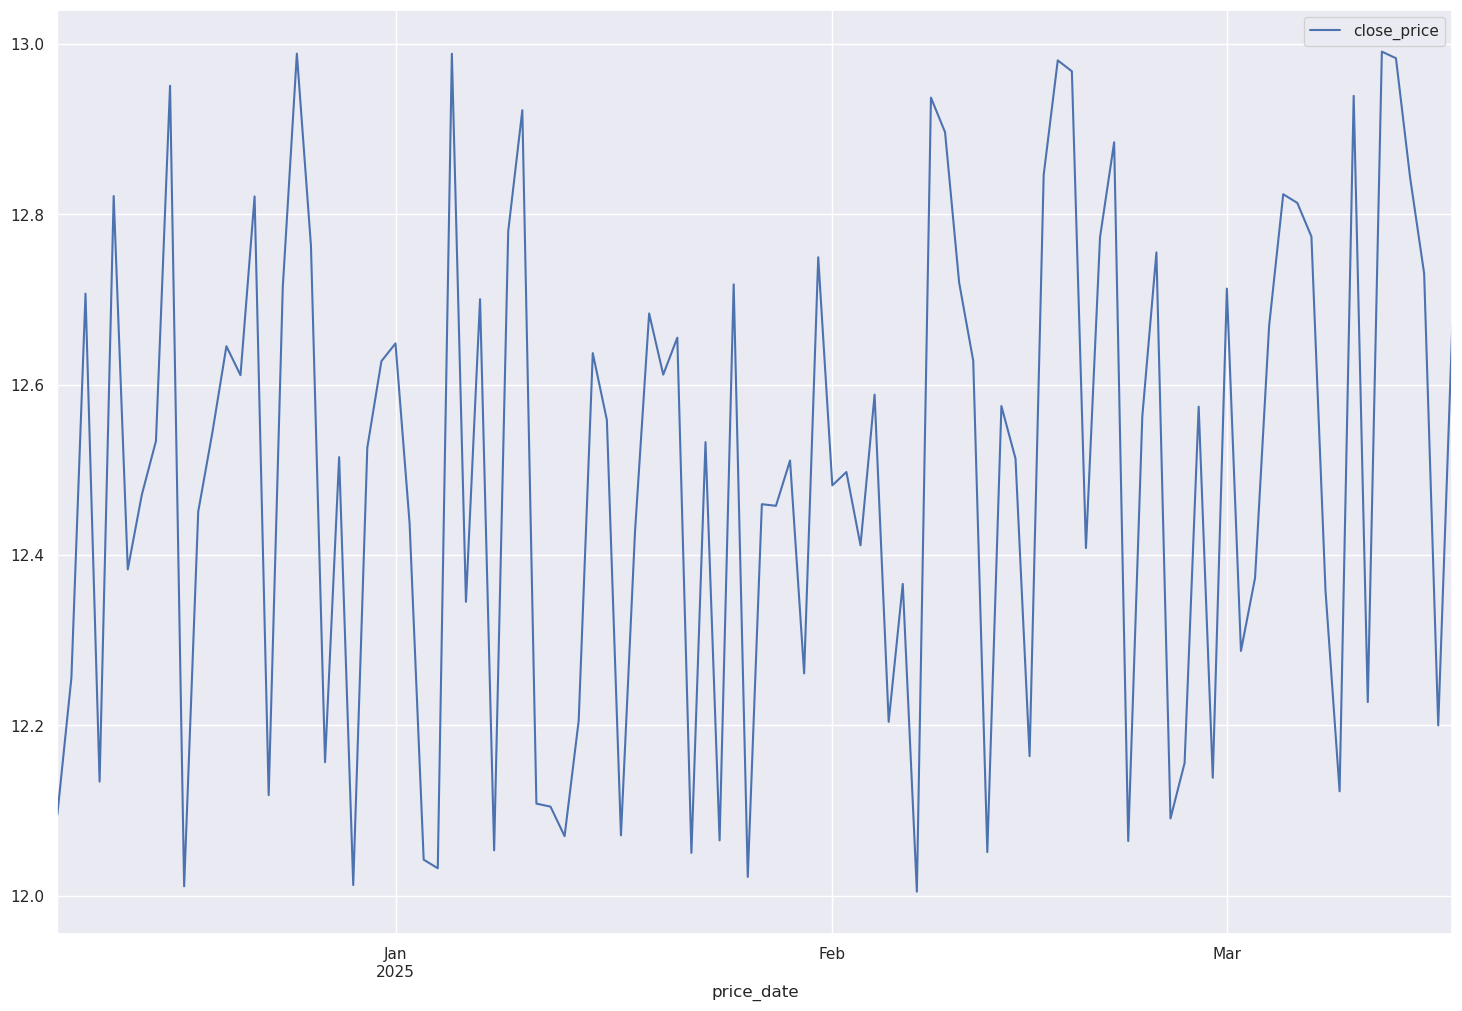

In [8]:
##train_close_prices['diff'] = train_close_prices['close_price'].diff()

train_close_prices.plot()

In [9]:
from statsmodels.tsa.stattools import adfuller
adf_test = adfuller(train_close_prices)
print(f'p-value: {adf_test[1]}')


p-value: 2.593488848742008e-18


In [10]:
from statsmodels.tsa.arima.model import ARIMA

##train_close_prices.index = pd.DatetimeIndex(train_close_prices.index).to_period('D')

model = ARIMA(train_close_prices, order=(3,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            close_price   No. Observations:                  100
Model:                 ARIMA(3, 0, 0)   Log Likelihood                 -21.263
Date:                Sun, 08 Dec 2024   AIC                             52.526
Time:                        10:34:41   BIC                             65.552
Sample:                    12-08-2024   HQIC                            57.798
                         - 03-17-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.4955      0.028    448.016      0.000      12.441      12.550
ar.L1         -0.0417      0.099     -0.421      0.674      -0.235       0.152
ar.L2      -4.838e-06      0.103  -4.69e-05      1.0

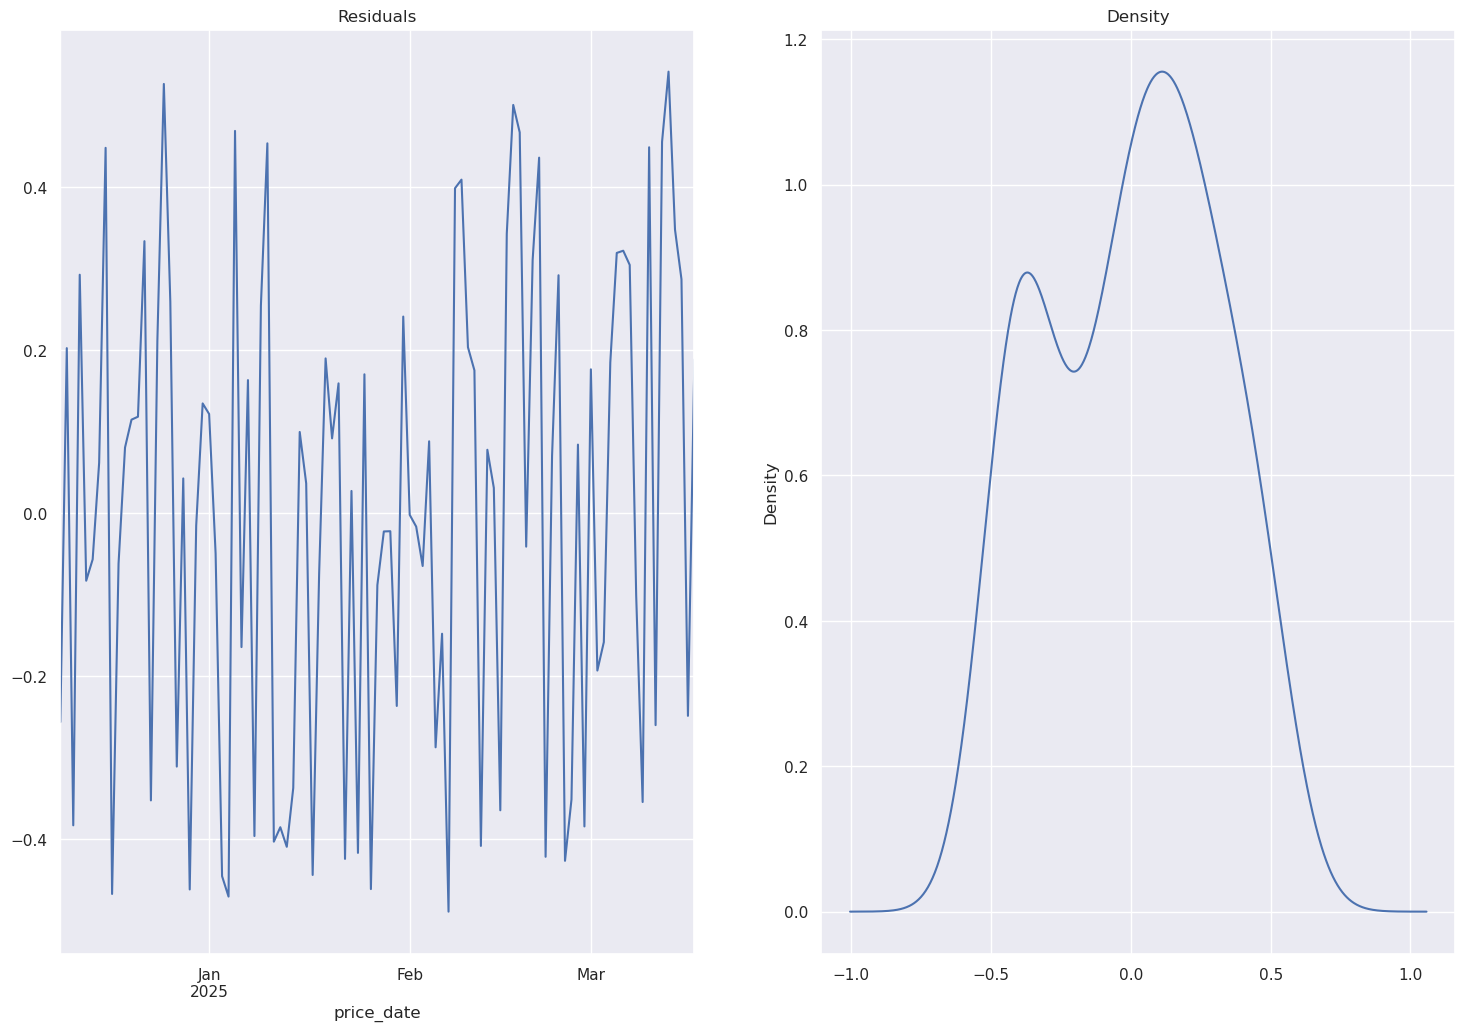

In [11]:
import matplotlib.pyplot as plt
residuals = model_fit.resid[1:]
fig, ax = plt.subplots(1,2)
residuals.plot(title='Residuals', ax=ax[0])
residuals.plot(title='Density', kind='kde', ax=ax[1])
plt.show()

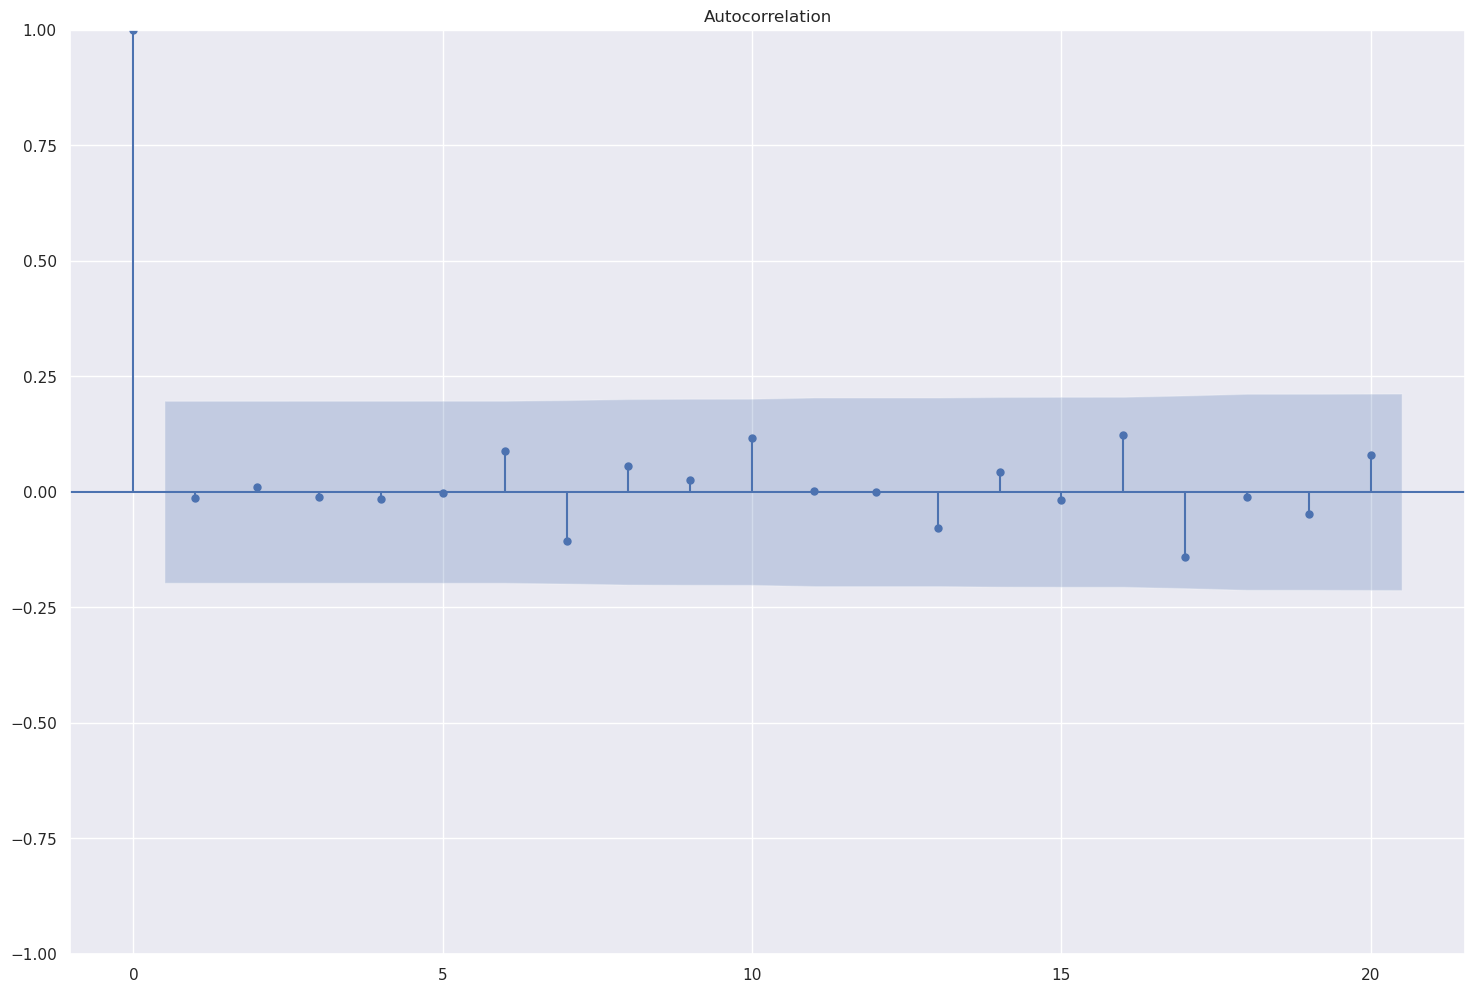

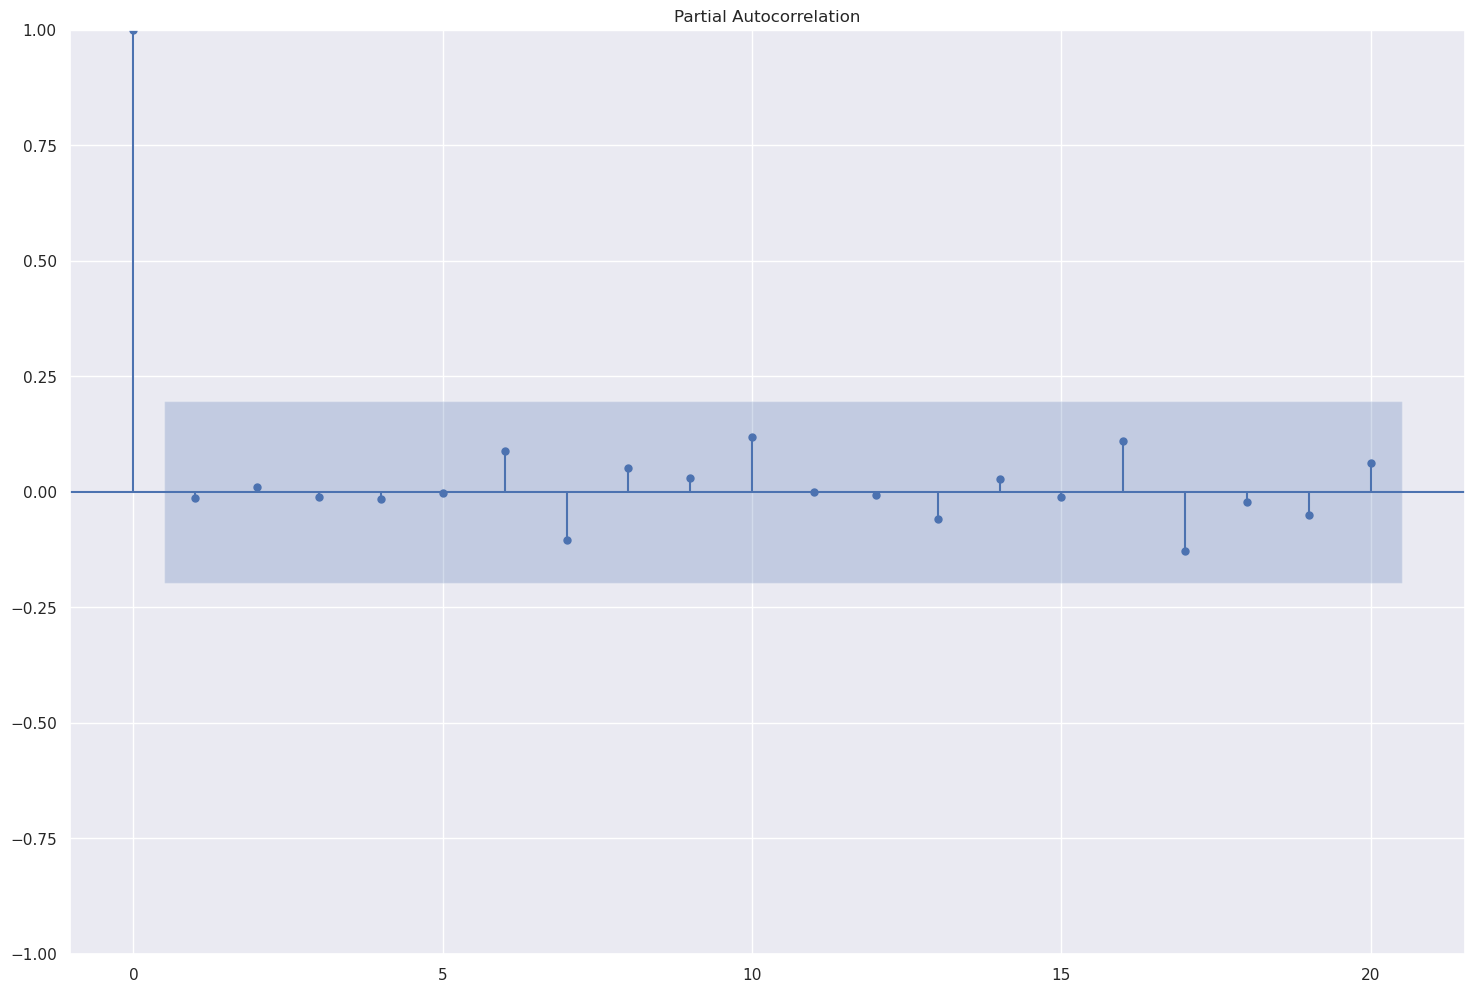

In [12]:
acf_res = plot_acf(residuals)

pacf_res = plot_pacf(residuals)

<Axes: xlabel='price_date'>

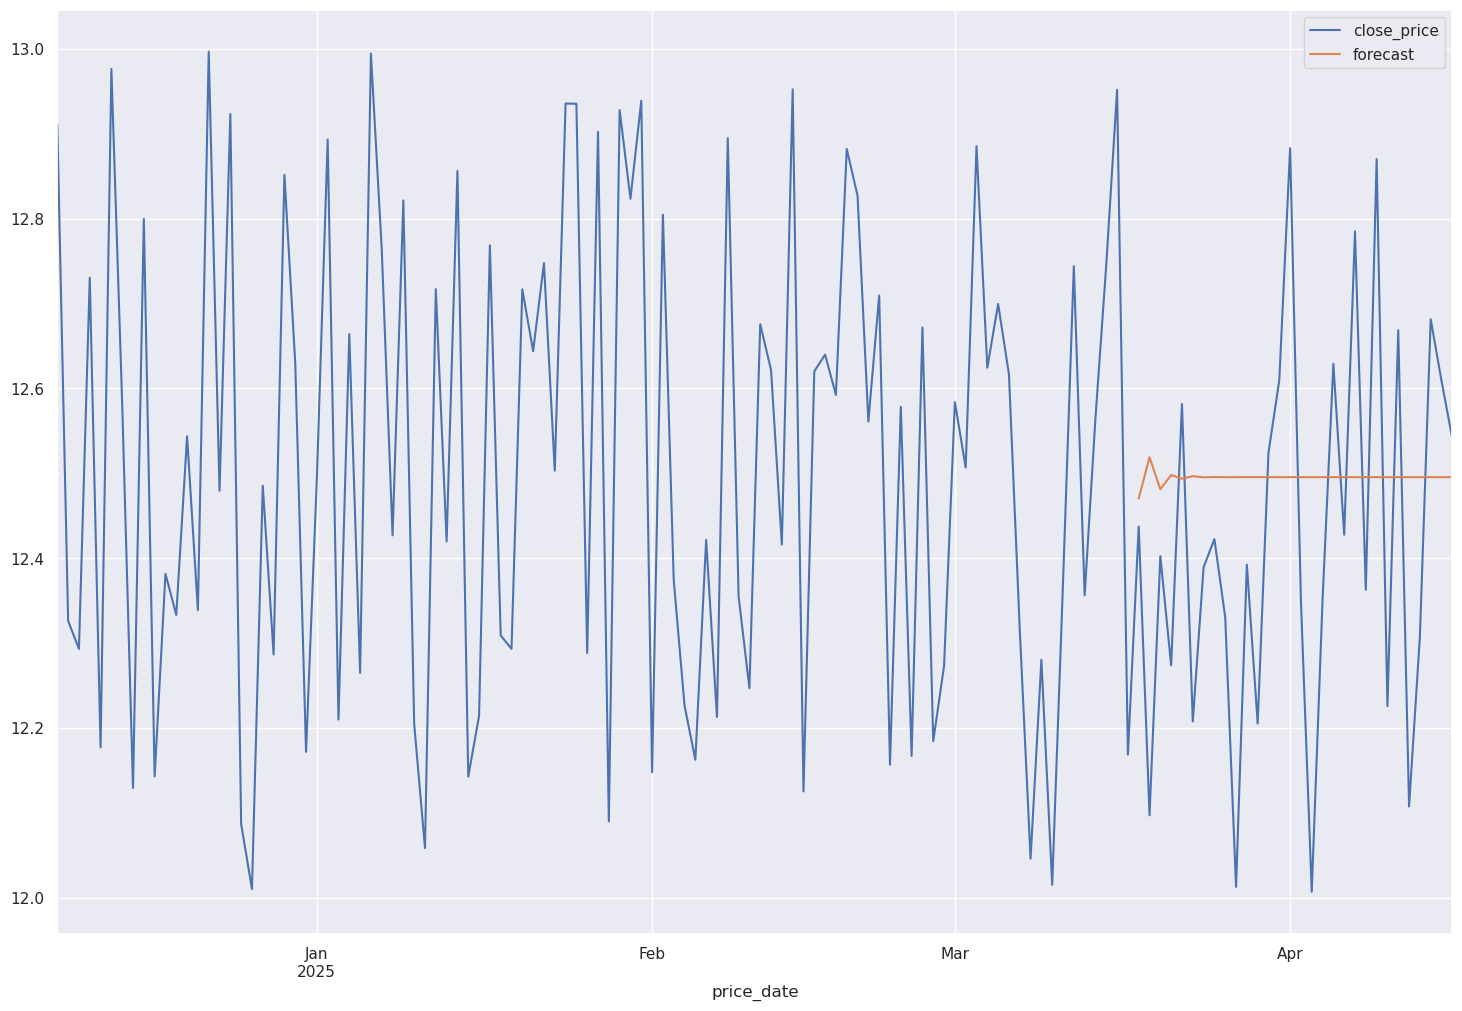

In [13]:
forecast_test = model_fit.forecast(predictdays)

close_prices_out = close_prices.copy()

##close_prices_out['forecast_manual'] = {0}*len(test_close_prices) + list(forecast_test)
first_bit = [None] * len(train_close_prices)



all  = first_bit + list(forecast_test)

close_prices_out['forecast'] = first_bit + list(forecast_test)

close_prices_out.plot()
##forecast_test.plot()
